In [32]:
# Generally useful
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Path
import os
import sys

# Callum imports
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
from scipy.interpolate import interp1d

# Arnold imports
from scipy.stats import describe
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import shutil

# My imports
from sympy import Symbol
from sympy.solvers import solve

In [33]:
class IV_curve(object):
    '''
    Main Methods:
    self.plotPV() - Plot PV graph
    self.plotIV() - plots IV graph
    self.plotPR() - plots PR graph
    '''
    
    def __init__(self, rawIV, params = 0, name='NA', tweaks = [1,1,1]):
        ''' Creates a TES object from a pandas dataframe. 
        
        Reads the first two columns of the dataframe and saves them as attributes. Next two columns will 
        be checked for T_BB and T_bath variables, but will be set to zero when not found. 
        Params can be a list or tuple of values in this order [R_fb, M_ratio, R_shunt]
        R_stray can be included as extra paramter. Doing so will prevent the calc_R_stray method being used to 
        generate a value.
        
        Attributes after initialisation:
        rawI (np.array[floats]), rawV (np.array[floats])
        raw_grad/raw_2grad (list[floats]) - 1st and 2nd differentials of rawIV
        superconducting (bool) - Whether the data shows signs of superconductivity
        y_offset (float) - Offset in the 
        I_TES (list[floats]), V_bias (list[floats]) - Calibrated data
        R_fb, M_ratio, R_shunt (floats)- Experimental parameters
        gain (float) - Calculated from M_ratio and R_fb
        R_stray (float) - Either input or calculated
        P_TES , R_TES (floats) - Power and Resistance values
        rnn (float) 
        
        ohmic_reg, trans_reg, super_reg (ints) the demarcated regions. 
        If not super conducting ohmic_reg will be the entire data range
        '''
        
        # Raw data
        self.df = rawIV
        
        # Drop NaNs in spreadsheet to prevent errors later 
        rawI = (rawIV.iloc[:,0].dropna()).values  # Store as individual np.arrays for more readable code
        self.rawI = [entry * tweaks[0] for entry in rawI]
        rawV = (rawIV.iloc[:,1].dropna()).values
        self.rawV = [entry * tweaks[1] for entry in rawV]
        
        # Search next columns for T_BB and T_bath, if non existent set them to 0.1 
        try:
            self.T_BB = rawIV.iloc[:,3].dropna().values
            self.T_bath = rawIV.iloc[:,4].dropna().values
        except IndexError:
            print("T_BB and T_bath not found")
            self.T_BB = 0.1
            self.T_bath = 0.1
            
        self.P = False
        
        # Obtaining Power Data if present in the raw data
        try:
            assert len(rawIV.columns) > 5
            self.P_BB = (rawIV.iloc[:,-1]).dropna()
            for entry in self.P_BB:
                if entry != 0:
                    self.P = True
        except:             # Find out which exeption (AssertionError or IndexError)
            print("Failed to parse Power Data")
        
        self.raw_grad = np.gradient(self.rawV, self.rawI) # Prevents repeated calls to gradient function later
        self.raw_2grad = np.gradient(self.raw_grad, self.rawI)
        self.superconducting = self.calc_superconducting() # This needs to be done first as other inits depend on it
        
        # Initialise these values with the methods
        self.name = name
        self.y_offset = 0
        self.n_fit = 10
        
        # Parameters needed to calculate V_bias and I_TES. Defaults are used when not provided. 
        # I DO NOT KNOW WHERE THESE DEFAULT NUMBERS ARE BASED ON, ASK CALLUM
        if params:
            try:
                self.R_fb = params[0]
                self.M_ratio = params[1]
                self.R_shunt = params[2]
            except IndexError:
                print("Error: Parameters not correct")
                return
        else:
            print("WARNING: Using default parameters")
            self.R_fb = 100099.6
            self.M_ratio = 18.9333333333333
            self.R_shunt = 0.00389
        
        self.gain = 1 / (self.R_fb * self.M_ratio)
        
        
    ############################# Calculation Methods ##########################################   
    # For formulas see Callum's Thesis
    
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_TES (array) data from the y_offset (float), gain (float) and voltage (array).
        '''
        self.I_TES = [(self.rawV[i] - self.y_offset) * (10**6) * self.gain for i in range(len(self.rawV))]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generate V_bias (array) data from R_shunt (float), R_stray(float), rawI (array) and I_TES (array)
        '''
        self.V_bias = [((self.rawI[i]) * self.R_shunt) - (self.I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
        
    def calc_P_TES(self):
        '''
        Generate P_TES (array) data from I_TES (array) and V_bias (array) 
        '''
        self.P_TES = [self.I_TES[i] * self.V_bias[i] for i in range(len(self.I_TES))]
        
    def calc_R_TES(self):
        '''
        Generate R_TES (array) data from V_bias (array) and I_TES (array)
        '''
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]
        
    def calc_superconducting(self):
        '''
        Tests if the gradient deviates from the average by a significant margin. And save result in attribute.
        Returns the boolean value of self.superconducting
        NOTE: Might be deprecated after classifying is introduced
        '''
        grad = self.raw_grad
        grad_av = sum(grad)/len(grad)
        if abs(min(grad)) > 2*(grad_av) and min(grad) < 0:
            self.superconducting = True
        else:
            self.superconducting = False
    
        return self.superconducting
    
    # NEW ____________________
    def find_superconducting(self, x_vals, y_vals):
        y_prev = y_vals[0]
        x_prev = x_vals[0]

        ymin, ymax = min(y_vals), max(y_vals)
        change = abs(ymin - ymax) * 0.1  # 10% of total range

        index = 1
        points = []
        for x, y in zip(x_vals[1:], y_vals[1:]):
            if abs(y - y_prev) > change:
                # Second point needs to be inside the superconducting region
                if len(points) == 1:
                    points.append([x_prev, y_prev, index])
                else:
                    points.append([x, y, index + 1])
            index += 1
            y_prev = y
            x_prev = x
        
        #print(points)
        self.points = points
        
        # Create Single sided dataset
        index = points[0][2]
        x = self.V_bias[index:]
        y = self.I_TES[index:]
        
        self.x_single = x
        self.y_single = y
        return points
    
    # NEW____________________ (temporary maybe)
    def calc_distance_old(self, A, B, double=True):
        norm = np.sqrt(A**2 + B**2)
        d_list = []
        for x, y in zip(self.V_bias[(-1*self.n_fit)-1:-1], self.I_TES[(-1*self.n_fit)-1:-1]):
            d = (A*x - y + B) / norm
            d_list.append(d)
            
        # Include left side points for double sided IV curves    
        if double:
            for x, y in zip(self.V_bias[0:self.n_fit], self.I_TES[0:self.n_fit]):
                d = (A*x - y + B) / norm
                d_list.append(d)
        
        return d_list
    
    # NEW______________________
    def calc_distance(self, popt, popt2=[0,0,0,0,0], double=True):
        d_list = []
        
        # for single: popt1 = right, for double: popt1 = left, popt2 = right
        A1, B1, C1, D1, x01 = popt[0], popt[1], popt[2], popt[3], popt[4]
        A2, B2, C2, D2, x02 = popt2[0], popt2[1], popt2[2], popt2[3], popt2[4]
        
        if not double:
            x_list = self.x_single[-1*self.n_fit:]
            y1_list = self.y_single[-1*self.n_fit:]
            
            y2_list = []
            for x in x_list:
                y2_list.append(self.f_exp_right(x, A1, B1, C1, D1, x01))
        else:
            x_l1 = self.V_bias[0:self.n_fit]
            y1_l1 = self.I_TES[0:self.n_fit]
            y2_l1 = []
            for x in x_l1:
                y2_l1.append(self.f_exp_left(x, A1, B1, C1, D1, x01))
            
            
            x_l2 = self.V_bias[-1*self.n_fit:]
            y1_l2 = self.I_TES[-1*self.n_fit:]
            y2_l2 = []
            for x in x_l2:
                y2_l2.append(self.f_exp_right(x, A2, B2, C2, D2, x02))
            
            x_list = x_l1 + x_l2
            y1_list = y1_l1 + y1_l2
            y2_list = y2_l1 + y2_l2
    
        
        for y1, y2 in zip(y1_list, y2_list):
            # Positive y_diff: point above curve, negative diff: point below curve  
            y_diff = y1 - y2 
            d_list.append(y_diff)
            
        return d_list
    
    def calc_all(self):
        '''
        Calculates all values used for the plots and analysis.
        NOTE: Maybe implement calc_rnn func, so it doesn't need to be done in the plotIV function
        '''       
        self.power_readout()
        self.calc_I_TES()
        self.calc_V_bias()
        self.plotIV(False)
        self.reverse_y_offset()
        
        self.calc_I_TES()
        self.calc_V_bias()
        #self.plotIV(False)
        #self.calc_P_TES()
        #self.calc_R_TES()
        #self.power_readout(True)
    
    ############################ Utility methods ############################   
    
    def f(self, x, A, B):
        ''' 
        Function of straight line for optimisation function to find
        coefficients for.
        '''
        return A*x + B
    
    # NEW ____________________
    def f_exp_left(self, x, A, B, C, D, x0):
        return A*x + B - C*np.exp(D*(x-x0))
    
    # NEW ______________________
    def f_exp_right(self, x, A, B, C, D, x0):
        return A*x + B + C*np.exp(-D*(x-x0))
        
    def fit_ohmic(self, inputdataX, inputdataY, plot=False):
        ''' 
        Accepts two lists for X and Y vals and a tuple of indices. These are then used 
        to fit a straight line to the straight regions.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        # First 10 points and last 10 points taken to fit straight line through both ohmic regions.
        # This could be automated to rely less on just choosing a random number.
        r1start, r1end = (0, self.n_fit)   
        r2start, r2end = (-1*self.n_fit, -1)
        
        firstx1, lastx1 = min(inputdataX[r1start:r1end]), max(inputdataX[r1start:r1end])
        firstx2, lastx2 = min(inputdataX[r2start:]), max(inputdataX[r2start:])

        # Slice the data in the frame and store in an array 
        yvals1 = inputdataY[r1start:r1end]
        yvals2 = inputdataY[r2start:]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = inputdataX[r1start:r1end]
        xvals2 = inputdataX[r2start:]
        lineDataX = np.append(xvals1, xvals2)

        #popt1, pcov1 = curve_fit(self.f_exp_left, xvals1, yvals1, p0=[4.5, 0.0005, -0.5, 1, 0.04], maxfev=1_000_000)
        #popt2, pcov2 = curve_fit(self.f_exp_right, xvals2, yvals2, p0=[4.5, 0.0005, 0.5, 1, 0.04], maxfev=1_000_000)
        
        popt1, pcov1 = curve_fit(self.f_exp_left, xvals1, yvals1, 
                               p0=[4.5, 0.01, -0.5, 100, 0.02], bounds=((4, 0, -1, 0, 0), (5, 0.05, 1, 200, 0.1)))
        popt2, pcov2 = curve_fit(self.f_exp_right, xvals2, yvals2, 
                               p0=[4.5, 0.01, 0.5, 100, 0.02], bounds=((4, 0, 0, 0, 0), (5, 0.05, 1, 200, 0.1)))
        
        x_func_vals1 = np.linspace(1.2*firstx1, 0.5*lastx1, 1000)
        y_func_vals1 = self.f_exp_left(x_func_vals1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4])
        
        x_func_vals2 = np.linspace(0.8*firstx2, 1.5*lastx2, 1000)
        y_func_vals2 = self.f_exp_right(x_func_vals2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4])
        
        if plot:
            plt.scatter(xvals1, yvals1, s=2)
            plt.scatter(xvals2, yvals2, s=2)
            plt.plot(x_func_vals1, y_func_vals1, color='r')
            plt.plot(x_func_vals2, y_func_vals2, color='g')
            params_label = "A: "+str(popt1[0])+"\nB: "+str(popt1[1])+"\nC: "+str(popt1[2])+"\nD: "+str(popt1[3])+"\nx0: "+str(popt1[4])
            plt.plot([], [], ' ', label=params_label)
            #plt.ylim(0.9*min(self.I_TES), 1.1*max(self.I_TES))
            plt.legend()
            plt.show()
        
        return popt1, popt2
    
    # NEW________________________
    def fit_ohmic_single(self, inputdataX, inputdataY, plot=False):
        ''' 
        Accepts two lists for X and Y vals and a tuple of indices. These are then used 
        to fit a straight line to the straight regions.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        # First 10 points and last 10 points taken to fit straight line through both ohmic regions.
        # This could be automated to rely less on just choosing a random number.
        r1start, r1end = (-1*self.n_fit, -1)   
        
        firstx = min(inputdataX)
        lastx = max(inputdataX)
        xvals = np.linspace(firstx, lastx)

        # Slice the data in the frame and store in an array 
        yvals1 = inputdataY[r1start:]
        lineDataY = yvals1
        
        xvals1 = inputdataX[r1start:]
        lineDataX = xvals1

        # Fit the sliced data to a line
        #popt, pcov = curve_fit(self.f_exp_right, lineDataX, lineDataY, 
        #                       p0=[4.5, 0.01, 0.5, 100, 0.02], maxfev=100_000_000)
        
        popt, pcov = curve_fit(self.f_exp_right, lineDataX, lineDataY, 
                               p0=[4.5, 0.01, 0.5, 100, 0.02], bounds=((4, 0, 0, 0, 0), (5, 0.05, 1, 200, 0.1)))
        
        if plot:
            # x, y values for plotting fitted curve
            x_func_vals = np.linspace(firstx, lastx, 1000)
            y_func_vals = self.f_exp_right(x_func_vals, popt[0], popt[1], popt[2], popt[3], popt[4])
            
            plt.scatter(xvals1, yvals1, s=2)
            plt.plot(x_func_vals, y_func_vals, color='r')
            params_label = "A: "+str(popt[0])+"\nB: "+str(popt[1])+"\nC: "+str(popt[2])+"\nD: "+str(popt[3])+"\nx0: "+str(popt[4])
            plt.plot([], [], ' ', label=params_label)
            plt.ylim(0, 1)
            plt.legend()
            plt.show()
            
        return popt
    
    def power_readout(self, plot = 0):
        '''
        Looks for turning points from positive to negative gradient, as that denotes a different region.
        RETURNS: indices of the turning points and the corresponding power values
        '''
        indices = []
        
        # Look for three consecutive negative gradients and add the index of the first point to a list
        count = 0 
        for index in range(len(self.raw_grad)):
            if self.raw_grad[index] < 0:
                count += 1
            else:
                count = 0
                
            if count >= 3:
                indices.append(index-count)
                break
        
        # Same procedure but from the other side
        # NOTE: IMPLIES SYMMETRY, CHECK FOR SINGLE SIDED???
        count = 0
        for index in range(len(self.raw_grad)):
            if self.raw_grad[-index] < 0:
                count += 1
            else:
                count = 0
                
            if count >= 3:
                indices.append(-(index-count))
                break
        
        # Dependent upon the amount of points, change readout value
        readout = 0  
        if plot:
            if len(indices) == 2:
                readout = (self.P_TES[indices[0]] +  self.P_TES[indices[1]])/2
            elif len(indices) == 1:
                readout = self.P_TES[indices[0]]
            else:
                readout = 0
        
        self.readout_idx = indices
        self.readout = readout
        return readout
    
    def reject_outliers(self, data, m = 2.):
        '''
        Rejects outliers from the dataset, look into how it works!!!
        '''
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
    def y_search(self, step, pivot, precision):
        '''
        Recursive function where the step gets lowered continously until it is at the provided precision level.
        Returns pivot, the y_offset.
        '''
        ys = []
        counts = []
        
        # Recursive loop end 
        if step <= precision:
            self.y_offset = pivot
            return pivot
        
        # Loop over a small range of values around pivot, and saves value with lowest count
        for y_off in np.arange(pivot-(step*10), pivot+(step*10), step/10):
            # Necessary calculations for R_TES and P_TES
            I_TES = [(entry - y_off) * (10**6) * self.gain for entry in self.rawV]
            V_bias = [((self.rawI[i]) * self.R_shunt) - (I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
            P_TES = [I_TES[i] * V_bias[i] for i in range(len(I_TES))]
            P_grad = np.gradient(P_TES)
            P_grad_smooth = self.reject_outliers(P_grad)
            R_TES = [V_bias[i] / I_TES[i] for i in range(len(V_bias))]
            
            #  
            count = 0          
            for i in range(int(len(R_TES)/10)-1):
                count += np.sqrt((R_TES[i] - R_TES[-i])**2)
                count += (R_TES[i] - self.rnn)**2
                count += (R_TES[-i] - self.rnn)**2
                
            count += len(R_TES)*(self.rnn - max(R_TES))**2
            
            for entry in P_TES:
                if entry < 0:
                    count += 10 * (entry**2)
            
            for entry in R_TES:
                if entry < 0:
                    count += 10 * (entry**2)
            
                
            counts.append(count)
            ys.append(y_off)

        y_offset = ys[np.argmin(counts)]

        return self.y_search(step/10, y_offset, precision)
    
    def reverse_y_offset(self):
        '''Requires R_stray to have been already calculated or input.
        Attempts to calc offset through optimising the power plot. 
        '''
        self.y_search(5,0,0.000001)
    
    ############### Plotting Methods ###################
    
    def plotRaw(self):
        '''
        Plots raw IV data 
        '''
        plt.scatter(self.rawI, self.rawV, label='Raw IV', s=3)
        plt.grid()
        plt.xlabel("Current (μA)")
        plt.ylabel("Voltage (V)")
        plt.title(self.name)
        plt.show()
        
    def plotIV(self, plot = True):
        '''
        Plots the calibrated IV curve if plot is set to true in the args. Otherwise just calcs R_nn
        '''
        #C, D , Axvals = self.fit_ohmic(self.V_bias, self.I_TES)
        self.rnn = 0.22
        #print("rnn: " + str(self.rnn))
        if plot:
            fig, ax = plt.subplots()
            plt.plot(Axvals, self.f(Axvals, C , D), color='r', label='Load Line')
            plt.grid()
            plt.scatter(self.V_bias, self.I_TES, label='TES IV', s=3)
            
            # NEW --------------------- 
            points = self.find_superconducting(self.V_bias, self.I_TES)
            for point in points:
                plt.scatter(point[0], point[1], color="black", label="edge", s=3)
            # ------------------------
            
            if len(self.readout_idx) == 2:
                plt.scatter([self.V_bias[self.readout_idx[0]], self.V_bias[self.readout_idx[1]]], [self.I_TES[self.readout_idx[0]], self.I_TES[self.readout_idx[1]]])
            
            ax.set_xlabel("Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            ax.legend()
            plt.show()          
            
    # NEW _________________________
    def plotIV_single(self, plot = True):
        '''
        Plots the calibrated IV curve if plot is set to true in the args. Otherwise just calcs R_nn
        '''
        points = self.find_superconducting(self.V_bias, self.I_TES)
        C, D , Axvals = self.fit_ohmic_single(self.x_single, self.y_single)
        self.calc_distance(C, D, double=False)
        self.rnn = 1/C
        if plot:
            fig, ax = plt.subplots()
            plt.plot(Axvals, self.f(Axvals, C , D), color='r', label='Load Line')
            plt.grid()
            plt.scatter(self.x_single, self.y_single, label='TES IV', s=3)
            
            # NEW --------------------- 
            for point in points:
                plt.scatter(point[0], point[1], color="black", label="edge", s=3)
            # ------------------------
            
            if len(self.readout_idx) == 2:
                plt.scatter([self.V_bias[self.readout_idx[0]], self.V_bias[self.readout_idx[1]]], [self.I_TES[self.readout_idx[0]], self.I_TES[self.readout_idx[1]]])
            
            ax.set_xlabel("Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            ax.legend()
            plt.show()
            
    def plotPR(self, name = ''):
        '''
        Plots the Power - Resistance curve
        '''
        fig, ax = plt.subplots()
        plt.grid()
        plt.plot(self.R_TES, self.P_TES, label='TES PR')#, alpha=0.2)
        plt.title("Power vs Resistance Curve: Index - " + str(name))
        ax.set_xlabel("TES Resistance (ohm)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.power_readout(True)
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.axvline(self.rnn, color='r',label='Rnn: ' + str(round(self.rnn,5)))
        plt.legend()
        plt.show()
    
    def plotPV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.scatter(self.V_bias, self.P_TES, label='TES PV', s=3)
        plt.title("Power Curve")
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.superconducting:
            readout = self.power_readout(True)
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.legend()
        plt.show()

In [34]:
class IV_series(object):
    '''
    Main Methods:
    calc_R_nn(): calculates average rnn of all datasets
    '''
    
    def __init__(self, input_string, dirname, params):
        self.R_nn = 0
        self.R_stray = 0 
        self.series = self.read_data(dirname)
        self.data = [IV_curve(series[0], params, name=series[1]) for series in self.series]
        
        self.name = input_string
        
        print(self.data)
    
    def calc_distances(self, n_fit, double=True, plot=True):
        d_list = []
        a_sum = 0
        b_sum = 0
        for entry in self.data:
            entry.R_stray = 1/1000
            entry.n_fit = n_fit
            
            entry.calc_all()
            if double:
                popt1, popt2 = entry.fit_ohmic(entry.V_bias, entry.I_TES, plot=False)
                new_distances = entry.calc_distance(popt1, popt2=popt2, double=True)
                
                x_add = entry.V_bias[0:n_fit]
                y_add = entry.I_TES[0:n_fit]
                
 
            else:
                points = entry.find_superconducting(entry.V_bias, entry.I_TES)
                
                popt = entry.fit_ohmic_single(entry.x_single, entry.y_single, plot=False)
                new_distances = entry.calc_distance(popt, double=False)
                
                x_add = []
                y_add = []
                
            #var_tests = np.var(new_distances)
            #print(var_tests)
            
            d_list = d_list + new_distances
   
        mean_nf = np.mean(d_list)
        std_nf = np.std(d_list)
        var_nf = np.var(d_list)

        # Filter the distance list for outliers
        #if double:
        #    # Remove lowest and highest value in double plot, as it screws up the axis
        #    d_list.pop(d_list.index(min(d_list)))
        #    d_list.pop(d_list.index(max(d_list)))
        #else:
        #    # Remove lowest value in single plot, as it screws up the axis
        #    d_list.pop(d_list.index(min(d_list)))
        
        #n_filter = int(0.05*len(d_list))
        #d_list.sort()
        #d_list = d_list[n_filter:-n_filter]
        
        #mean_wf = np.mean(d_list)
        #std_wf = np.std(d_list)
        #var_wf = np.var(d_list)
        
        list_nf = [mean_nf, std_nf, var_nf]
        #list_wf = [mean_wf, std_wf, var_wf]
        
        # Plots
        if plot:
            plt.figure(figsize=(15, 10))
            plt.subplot(121)

            x = x_add + entry.V_bias[-n_fit:]
            y = y_add + entry.I_TES[-n_fit:]

            plt.xlim(min(entry.V_bias), max(entry.V_bias))
            plt.ylim(min(entry.I_TES), max(entry.I_TES))

            plt.title("Example of points used for fitting")
            plt.xlabel("Bias Voltage (mV)")
            plt.ylabel("TES Current (mA)")

            plt.scatter(x, y)

            #a_str = "avg_x_offset: " + str(a_sum / len(self.data)) 
            #b_str = "avg_y_offset: " + str(b_sum / len(self.data))
            #plt.plot([], [], ' ', label=a_str + "\n" + b_str)
            #plt.legend()

            # Second Plot
            plt.subplot(122)    
            plt.hist(d_list, bins=70)
            #plt.xlim(-0.0003, 0.0003)
            plt.title("Using " + str(n_fit) + " points to fit, Double sided: " + str(double) + ", Entries: " + str(len(d_list)))
            plt.xlabel("Difference in Y-axis")
            plt.ylabel("Count")

            save_name = "Distance plot (exp fit), DS - "+str(double)+", n_fit - "+str(n_fit)+", Entries - "+str(len(d_list))
            plt.savefig(save_name)
            plt.show()
            
        return list_nf
        
    def set_R_stray(self, val):
        self.R_stray = val
        
    def set_rnn(self, val):
        self.R_nn = val
        
    def calc_R_stray(self):
        pass # TODO impliment 
             
    def calc_R_nn(self):
        average = 0
        for IV_curve in self.data:
            IV_curve.plotIV(False)
            average += IV_curve.rnn
        
        IV_series.R_nn = average/len(self.data)
    
    def read_data(self, dirname):
        '''
        Checks for .qdp and .csv files in a directory 
        RETURNS: series list, which stores all read datasets
        '''
        series = []
        expnr = 1
        for filename in os.listdir(dirname):
            if filename.endswith(".qdp"):
                print(filename)
                
                # Store the dataframe and filename in a list
                series.append([read_qdp(dirname+ '\\' +filename, expnr), filename])
                expnr += 1
            if filename.endswith(".csv"):
                print(filename)
                series.append([read_excel(dirname+ '\\' +filename, expnr), filename])
                expnr += 1
                              
        return series    
        
    def plot_power(self, plot=True):
        powers = []
        t_bath = []
        
        for entry in self.data:
            if entry.superconducting and not entry.P and entry.valid:
                powers.append(entry.power_readout(True))
                t_bath.append(np.average(entry.T_bath))
                
            
        self.t_bath = t_bath
        self.powers = powers
        
        if plot:
            plt.figure(figsize=(10,5))
            plt.scatter(t_bath, powers)
            plt.axis([0,max(t_bath)*1.2,0,max(powers)*1.2])
            plt.xlabel('T bath (mK)')
            plt.ylabel('P Joule (pW)')
            plt.grid()
            plt.show()
            
    def fit_power(self, plot=True, save=False, xtweak=0.001, ytweak=1):
        def f2(x, K, T_c, n):
                return K*(T_c**n - x**n)
            
        xdata = [entry*xtweak for entry in self.t_bath]
        ydata = [entry*ytweak for entry in self.powers]

        
        popt, pcov = curve_fit(f2, xdata, ydata,maxfev=1000000)#, p0=(0,0,0))
        self.G = popt[0] * (popt[1]**(popt[2]-1)) * popt[2]
        if plot:
            nxdata = np.arange(0, max(xdata)*1.2, 0.0001)
            plt.figure(figsize=(10,5))
            plt.scatter(xdata, ydata)
            plt.plot(nxdata, f2(nxdata, *popt), 'r-')
            plt.axis([0,max(xdata)*1.2,0,max(ydata)*1.2])
            plt.grid()
            plt.xlabel('T bath (K)')
            plt.ylabel('P Joule (fW)')
            plt.figtext(.7, .8, "K: " + '{:.4e}'.format(popt[0]) + " $\\frac{fW}{K^n}$", backgroundcolor='w' )
            plt.figtext(.7, .75, "n: " + str(round(popt[2],4)), backgroundcolor='w')
            plt.figtext(.7, .7, "$T_c$: " + str(round(popt[1],4)) + ' K' , backgroundcolor='w')
            plt.figtext(.7, .65, "G: " + '{:.4e}'.format(self.G) + ' fW/K', backgroundcolor='w')
            if save:
                plt.savefig(str(self.name) + '.png')
            plt.show()

        return popt
    
    def valid_entries(self):
        with open(str(self.name) + "_errors.txt", "a") as text_file:
            for idx in range(len(self.data)):
                if np.average(self.data[idx].P_TES) < 0 or self.data[idx].readout <= 0:
                    self.data[idx].valid = False
                    print(f"entry: {idx} is not valid| file: {self.data[idx].name}|  super: {self.data[idx].superconducting} | readout: {self.data[idx].readout} | powerAv: {np.average(self.data[idx].P_TES)}"   , file=text_file)
                else:
                    self.data[idx].valid = True
                    
    def analyse_IV(self, R_stray, xtweak=0.001, ytweak=1, debug=False):
        for entry in self.data:
            entry.R_stray = R_stray
            entry.calc_all()
            
        self.valid_entries()
            
        self.plot_power(plot=True)
        params = self.fit_power(save=True, xtweak=xtweak, ytweak=ytweak)
        
        with open(str(self.name) + ".txt", "w") as text_file:
            print(f"K: {params[0]} | n: {params[2]} | Tc: {params[1]} | G: {self.G}", file=text_file)
            
        if debug:
            for entry in self.data:
                entry.plotRaw()
                entry.plotIV()
                entry.plotPV()
                entry.plotPR()

In [35]:
def read_qdp(filelocation, expnr, make_excel=False):
    '''
    Accepts a raw sting literal for the filename and path.
    x and y are strings which name the first 2 columns, default to bias
    and V fb (V)
    If make_excel is set to True then excel file is created in the name
    of the input file.
    Returns a pandas dataframe containing the data.
    '''

    # Name first two cols
    x = 'Current ' + str(expnr + 1) + ' (I)'
    y = 'V_fb ' + str(expnr + 1) + ' (V)'
    cols = {0: x, 1: y}
    header = 0

    # Skip all rows until a number is found (which is valid data)
    with open(filelocation) as file:
        for line in file:
            if line[0].isdigit():
                break
            header += 1
    df = pd.read_csv(filelocation, sep='\\s+', header=None, skiprows=header, index_col=False, comment='!')

    # Make list of col names for df and number ones without labels
    col_names = []
    for i in range(len(df.columns)):
        try:
            col_names.append(cols[i])
        except KeyError:    # Give column different name if column name does not exist in .qdp file
            col_names.append(str(i))

    # Set column names and sort by x vals
    df.columns = col_names
    df.sort_values(by=[x], inplace=True)

    # No idea what the purpose of this is, ask Callum
    if df.iloc[:, 0][1] * df.iloc[:, 1][1] < 0:
        df.iloc[:, 1] *= -1

    # Make excel file
    if make_excel:
        # Find name for excel sheet from end of path
        name_match = re.search(r'(\\?((?:.(?!\\))+)$)', filelocation)  # Also no clue what this does, ask Callum
        name = re.sub(r'(\.qdp|\\)', r'', name_match.group(1))
        # Write to file and save
        writer = pd.ExcelWriter(str(name) + '.xlsx')
        df.to_excel(writer, 'Sheet1', index=False)
        writer.save()

    return df

def read_excel(filename, expnr):
        dataDict = pd.read_excel(filename, sheet_name=None)
        for name, sheet in dataDict.items():
            new1 = sheet.iloc[:,0]
            new2 = sheet.iloc[:,1]
            new3 = sheet.iloc[:,2]
            try:
                new4 = sheet[['T bath', 'T BB', 'P BB']].copy()
                df = pd.concat([new1,new2,new3,new4], axis=1)
            except:
                print("Cannot find T BB and T bath or PBB: Please rename in sheet")
                df = pd.concat([new1,new2], axis=1)           
        
        return df

In [36]:
s = IV_series('test', 'C:/Users/Tom/Desktop/SRON_data_double_selected', [100002.9, 3.18541, 0.004567])

IVW17C04P03ShClosed_26.91mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_29.39mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_34.45mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_37.00mK_BB3.19K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_44.66mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_49.79mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mmGBon_29.38mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mm_27.04mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mm_29.39mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
[<__main__.IV_curve object at 0x0000024BBCAFAC08>, <__main__.IV_curve object at 0x0000024BBA9A71C8>, <__main__.IV_curve object at 0x0000024BBA992A88>, <__main__.IV_curve object at 0x0000024BBB7D2B48>, <__main__.IV_curve object at 0x0000024BBB7C0748>, <__main__.IV_curve obj

In [37]:
# Note that double  use double the amount of points for fitting straight line)
for n in range(10, 21, 10):
    #s.calc_distances(n, double=True)
    #s.calc_distances(n, double=False)
    a = 1
 

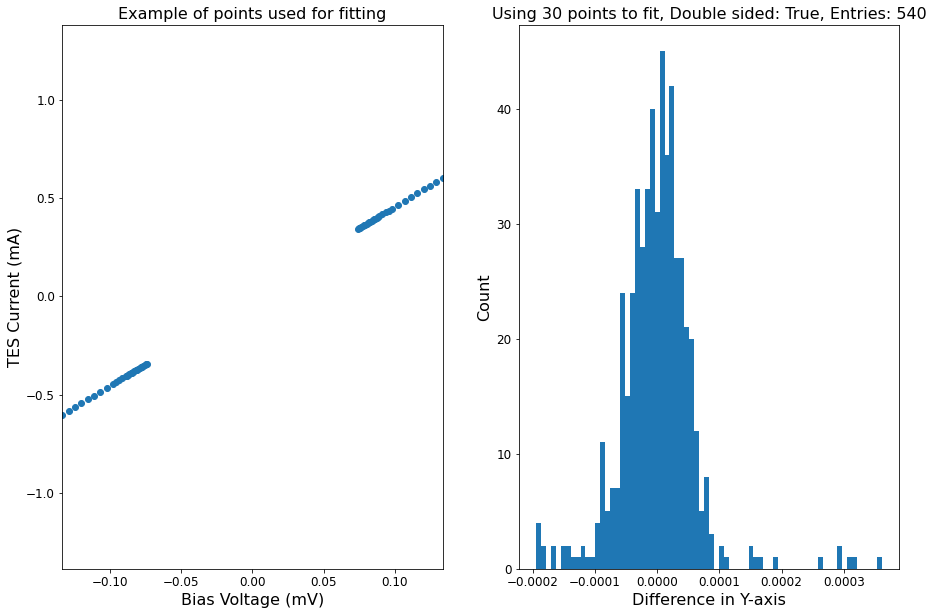

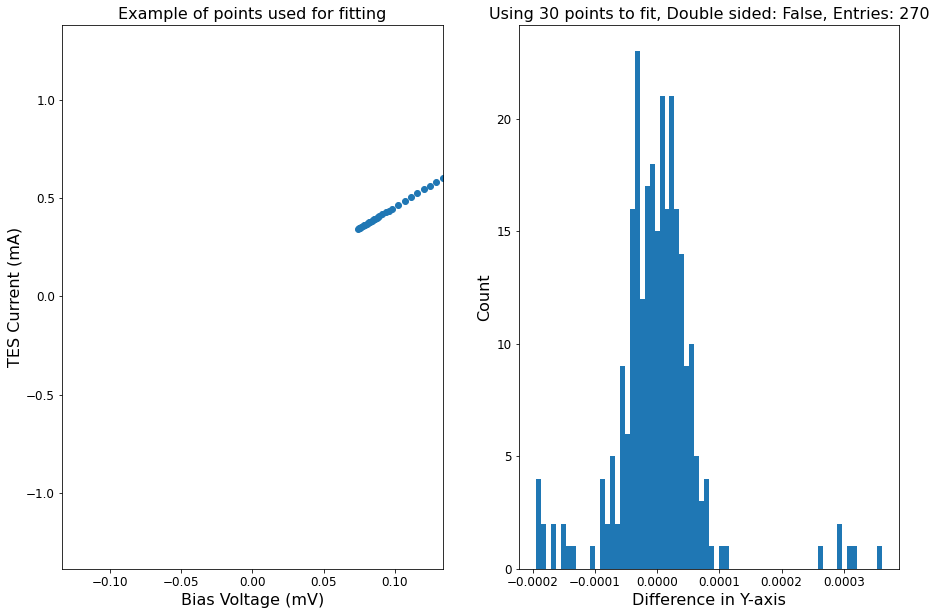

[[-1.5978623739780844e-08, 6.966413894837223e-05, 4.853092255418113e-09]]


In [38]:
list_nf = []
for n in range(30, 151, 1000):
    list_nf_n = s.calc_distances(n, double=True, plot=True)
    list_nf_n = s.calc_distances(n, double=False, plot=True)
    list_nf.append(list_nf_n)
    
print(list_nf)

rnn: 0.22095348676555088
rnn: 0.22095348676301965
rnn: 0.22095348676301965
[[-0.006456168558793805, -1.7104272279084773, 139], [0.006522018316596488, 1.6985986383983853, 209]]


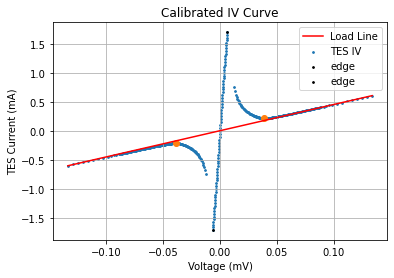

[[-0.006456168558793805, -1.7104272279084773, 139], [0.006522018316596488, 1.6985986383983853, 209]]
rnn: 0.2293766680557525


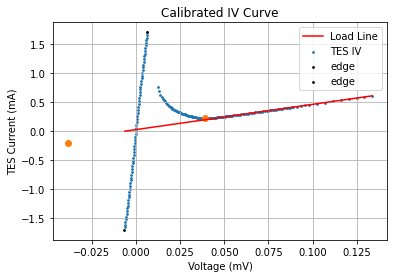

rnn: 0.22675799141142883
rnn: 0.2267579915198039
rnn: 0.2267579915198039
[[-0.006466898853722472, -1.7084997454352122, 152], [0.0065281349342268345, 1.6974999106041788, 222]]


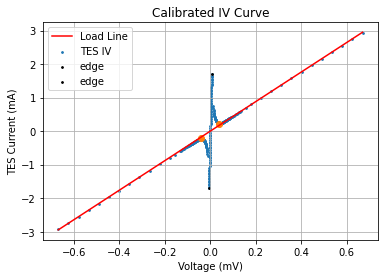

[[-0.006466898853722472, -1.7084997454352122, 152], [0.0065281349342268345, 1.6974999106041788, 222]]
rnn: 0.2283921165362008


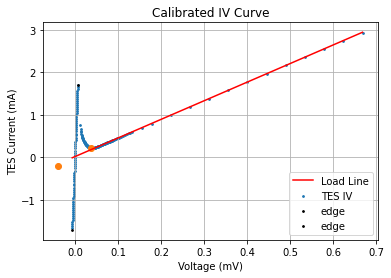

rnn: 0.22097398119550232
rnn: 0.2209739812167729
rnn: 0.2209739812167729
[[-0.006475182501599, -1.7070117540796297, 139], [0.006537851618233902, 1.695754503022525, 209]]


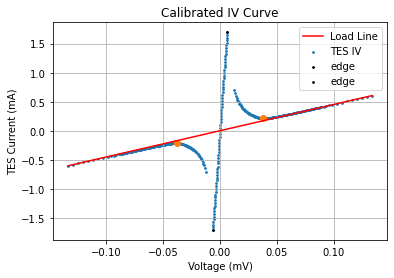

[[-0.006475182501599, -1.7070117540796297, 139], [0.006537851618233902, 1.695754503022525, 209]]
rnn: 0.22919852039462985


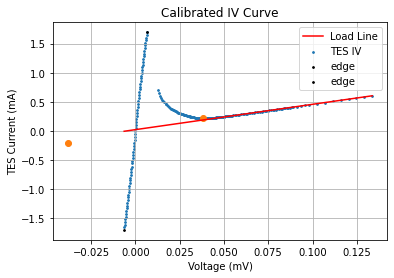

rnn: 0.22104257343645176
rnn: 0.22104257340817005
rnn: 0.22104257340817005
[[-0.006358424235277636, -1.6532415854422964, 140], [0.0064074969847227915, 1.6444266493105997, 208]]


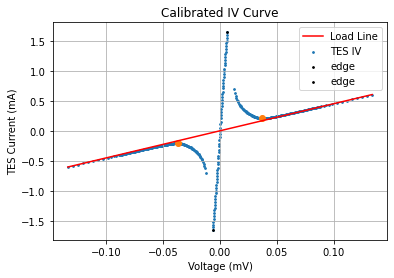

[[-0.006358424235277636, -1.6532415854422964, 140], [0.0064074969847227915, 1.6444266493105997, 208]]
rnn: 0.2292057959815075


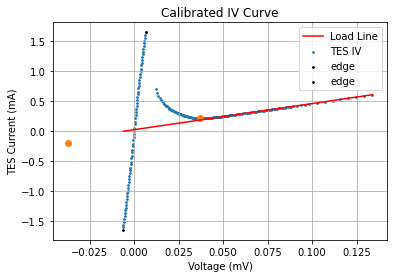

rnn: 0.2211068462733302
rnn: 0.22110684625020688
rnn: 0.22110684625020688
[[-0.0061718157881920695, -1.597069911769055, 141], [0.006221150678392811, 1.588207887303321, 207]]


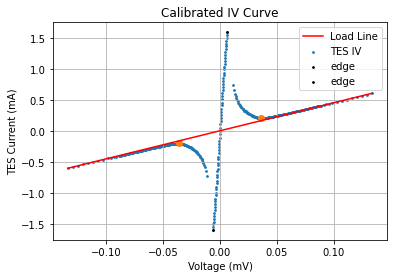

[[-0.0061718157881920695, -1.597069911769055, 141], [0.006221150678392811, 1.588207887303321, 207]]
rnn: 0.2291090695631718


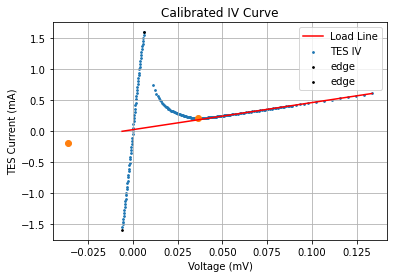

rnn: 0.22122372771822152
rnn: 0.2212237277395396
rnn: 0.2212237277395396
[[-0.005838888335580187, -1.4924380639267674, 143], [0.005892295145517704, 1.4828446006723184, 205]]


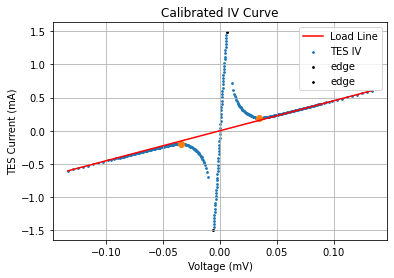

[[-0.005838888335580187, -1.4924380639267674, 143], [0.005892295145517704, 1.4828446006723184, 205]]
rnn: 0.2292897906036454


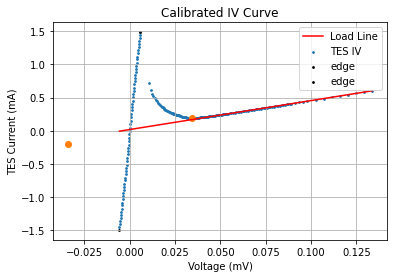

rnn: 0.22131019980790387
rnn: 0.22131019980692868
rnn: 0.22131019980692868
[[-0.005708105538834949, -1.4411871211604368, 144], [0.005757982186597238, 1.4322277808043582, 204]]


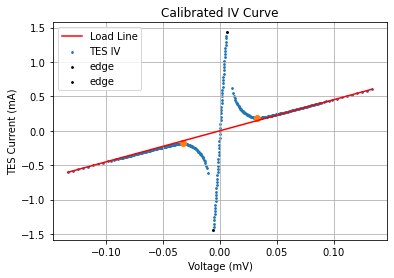

[[-0.005708105538834949, -1.4411871211604368, 144], [0.005757982186597238, 1.4322277808043582, 204]]
rnn: 0.2290683942761345


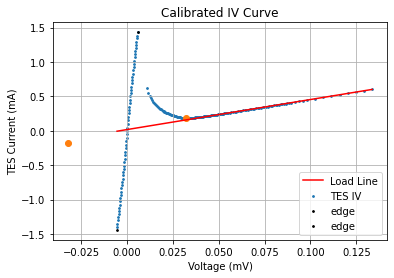

rnn: 0.22119373577948856
rnn: 0.22119373578907225
rnn: 0.22119373578907225
[[-0.0049243055438876185, -1.327853349188033, 147], [0.00495992173454601, 1.3214556142035907, 201]]


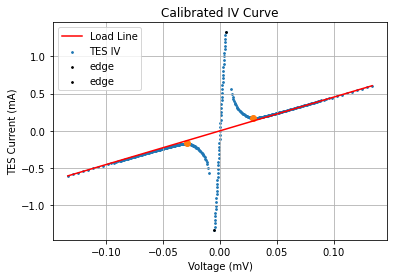

[[-0.0049243055438876185, -1.327853349188033, 147], [0.00495992173454601, 1.3214556142035907, 201]]
rnn: 0.22873899005804144


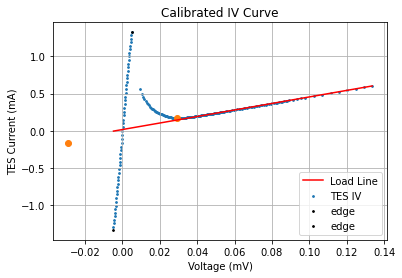

rnn: 0.2211353085241576
rnn: 0.2211353085567616
rnn: 0.2211353085567616
[[-0.005278877084885749, -1.4285972702499643, 145], [0.005318547719230541, 1.4214712356990764, 203]]


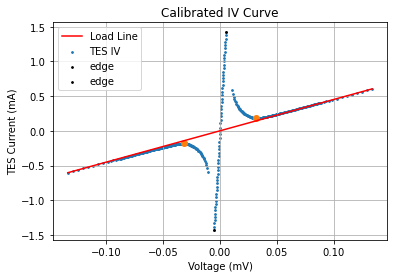

[[-0.005278877084885749, -1.4285972702499643, 145], [0.005318547719230541, 1.4214712356990764, 203]]
rnn: 0.22891722369887843


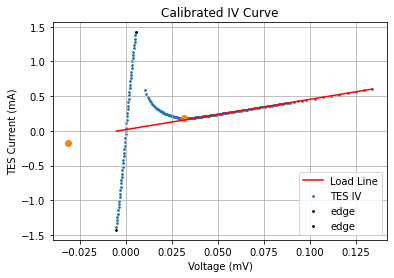

rnn: 0.22114136014265579
rnn: 0.22114136015332603
rnn: 0.22114136015332603
[[-0.005111394581901723, -1.383938694248873, 146], [0.005146014637688887, 1.3777198949337726, 202]]


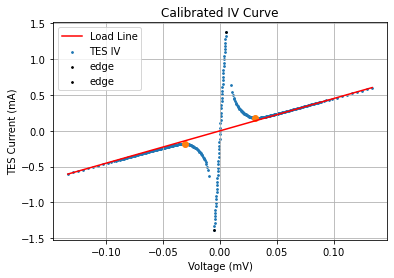

[[-0.005111394581901723, -1.383938694248873, 146], [0.005146014637688887, 1.3777198949337726, 202]]
rnn: 0.22879709518338426


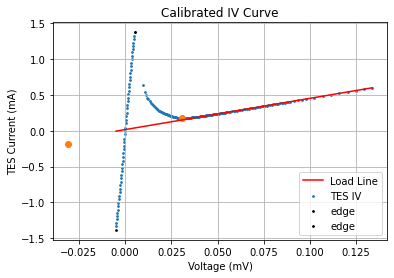

In [65]:
for entry in s.data:    
    for i in range(10, 11):   # was 10
        entry.R_stray = 1/1000
        entry.n_fit = i
        entry.calc_all()  
        entry.plotIV()
        #entry.plotRaw()
        plt.show()
        
        entry.plotIV_single()

In [66]:
# first = s.data[0]
# first.R_stray = 1/1000
# first.calc_all()
# first.plotIV()

# first.points

139


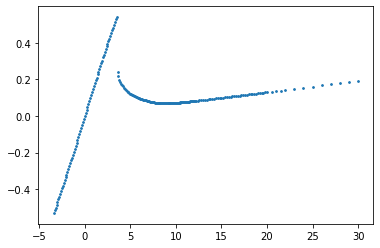

In [37]:
#first.plotPR()
coords = first.points
index = coords[0][2]
x = first.rawI[index:]
y = first.rawV[index:]
print(index)

plt.scatter(x, y, s=3)
plt.show()


In [67]:
#first.plotPV()

In [38]:
single_sided = IV_series('C:/Users/Tom/Desktop/SRON_data_single/2010-12-17', [100002.9, 3.18541, 0.004567])

IVpx13_108p47mK.qdp
IVpx13_114p24mK.qdp
IVpx13_120p0mK.qdp
IVpx13_125p7mK.qdp
IVpx13_131p3mK.qdp
IVpx13_136p8mK.qdp
IVpx13_142p3mK.qdp
IVpx13_147p8mK.qdp
IVpx13_149p9mK.qdp
IVpx13_152p0mK.qdp
IVpx13_48p3mK.qdp
IVpx13_92p14mK.qdp
IVpx13_92p1mK.qdp
IVpx13_96p8mK.qdp
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
T_BB and T_bath not found
[<__main__.IV_curve object at 0x000001F5CD1F7E48>, <__main__.IV_curve object at 0x000001F5CD1ED448>, <__main__.IV_curve object at 0x000001F5CD1EDF48>, <__main__.IV_curve object at 0x000001F5CD1ED2C8>, <__main__.IV_curve object at 0x000001F5CD1ED088>, <__main__.IV_curve object at 0x000001F5CD1ED808>, <__main__.IV_curve object at 0x000001F5CD1F71C8>, <__main__.IV_curve o

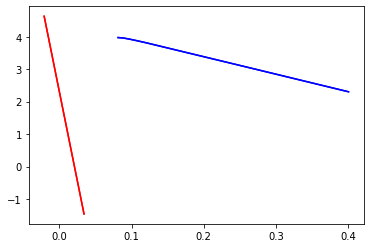

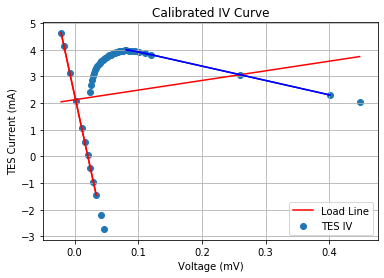

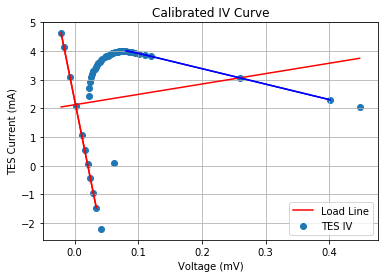

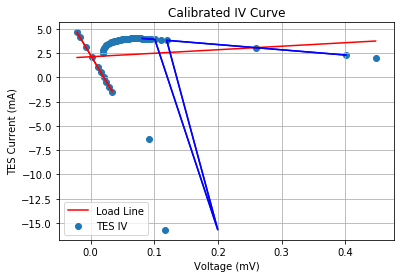

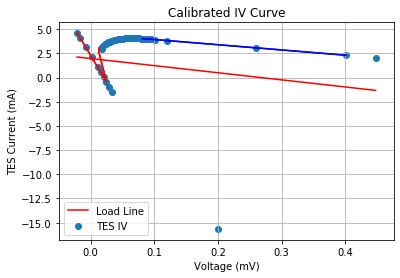

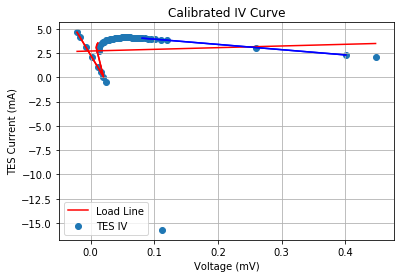

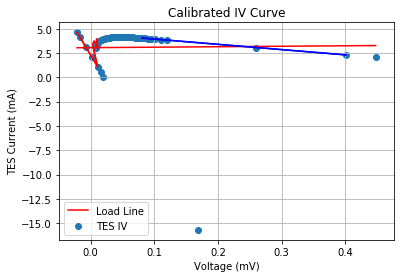

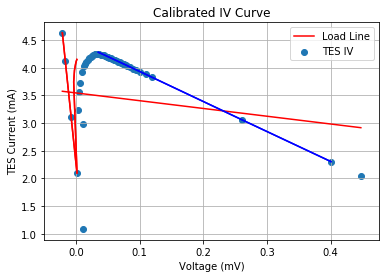

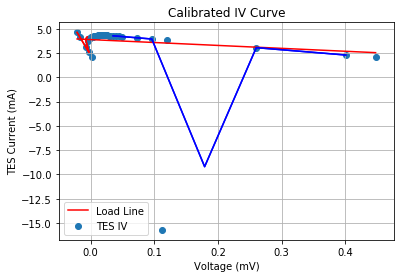

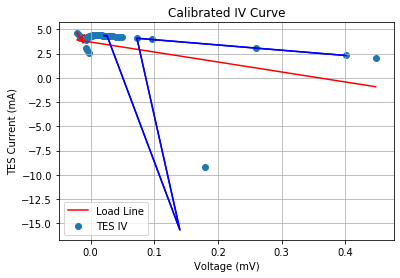

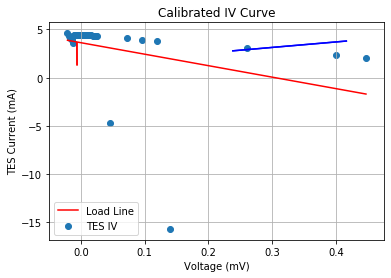

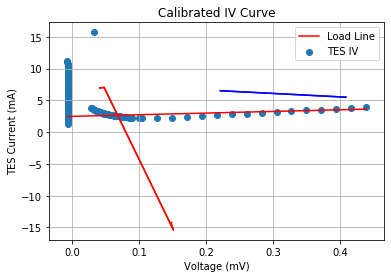

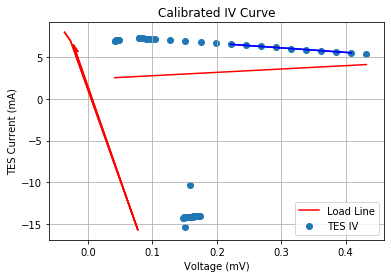

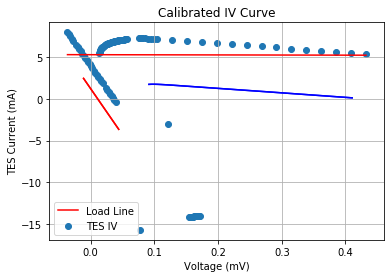

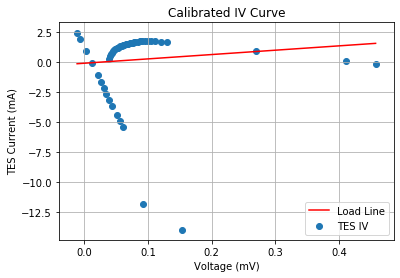

In [45]:
for entry in single_sided.data:    
    for i in range(1):   # was 10
        entry.R_stray = i/1000
        #entry.plotRaw()
        entry.calc_all()  
        entry.plotIV()

In [80]:
s = IV_series('C:/Users/Tom/Desktop/SRON_data_double', [100002.9, 3.18541, 0.004567])
s.data[0].rawI
s.data[0].rawV

IVW17C04P03ShClosed_26.91mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_26.95mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.74mA_PBB0pc.qdp
IVW17C04P03ShClosed_29.39mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_34.45mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_37.00mK_BB3.19K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_44.66mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShClosed_49.79mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mmGBon_29.38mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mm_27.04mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen1mm_29.39mK_BB3.21K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen2mm_26.91mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P03ShOpen2mm_44.66mK_BB3.20K_magnet0uA_HTRV0.00mV_HTRI33.73mA_PBB0pc.qdp
IVW17C04P05ShClosed_27.03mK_BB3

array([-0.191534  , -0.185354  , -0.179256  , -0.173072  , -0.166861  ,
       -0.160649  , -0.15445   , -0.148266  , -0.142071  , -0.139056  ,
       -0.135907  , -0.13289   , -0.129888  , -0.12864   , -0.127404  ,
       -0.126191  , -0.124967  , -0.123729  , -0.122513  , -0.121287  ,
       -0.120048  , -0.118836  , -0.117605  , -0.116372  , -0.11516   ,
       -0.11393   , -0.112727  , -0.111482  , -0.110263  , -0.109069  ,
       -0.107848  , -0.106621  , -0.105432  , -0.104207  , -0.102994  ,
       -0.101798  , -0.100578  , -0.099368  , -0.0981974 , -0.0969796 ,
       -0.0957735 , -0.0945969 , -0.093401  , -0.0921842 , -0.0910239 ,
       -0.0898413 , -0.0886689 , -0.0875161 , -0.0863354 , -0.0851811 ,
       -0.0841308 , -0.0830098 , -0.082387  , -0.0818873 , -0.0812874 ,
       -0.0807846 , -0.0801766 , -0.0796757 , -0.0790708 , -0.0785767 ,
       -0.078     , -0.0775126 , -0.076941  , -0.0764726 , -0.0759084 ,
       -0.075449  , -0.0749134 , -0.0744617 , -0.0739454 , -0.07

In [ ]:
def find_superconducting(self, x_vals, y_vals):
        y_prev = y_vals[0]
        x_prev = x_vals[0]

        ymin, ymax = min(y_vals), max(y_vals)
        change = abs(ymin - ymax) * 0.1  # 10% of total range

        index = 1
        points = []
        for x, y in zip(x_vals[1:], y_vals[1:]):
            if abs(y - y_prev) > change:
                # Second point needs to be inside the superconducting region
                if len(points) == 1:
                    points.append([x_prev, y_prev, index])
                else:
                    points.append([x, y, index + 1])
            index += 1
            y_prev = y
            x_prev = x
        
        print(points)
        self.points = points
        return points
    
    
    
# NEW --------------------- PLOTIV
            points = self.find_superconducting(self.V_bias, self.I_TES)
            for point in points:
                plt.scatter(point[0], point[1], color="black", label="edge", s=3)
            # ------------------------